In [2]:
# Save and restore models for additional training
# import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import preprocessing
import sys
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot') # use this plot style
%matplotlib inline

In [3]:
print('Python version ' + sys.version)
print('Tensorflow version ' + tf.VERSION)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]
Tensorflow version 1.13.1
Pandas version 0.24.2
Numpy version 1.16.2


In [4]:
def normalize(array):
    u = array.mean()
    s = array.std()
    norm = (array - u) / s
    return u, s, norm

def min_max(array, min=0, max=1):
    X_std = (array - array.min(axis=0)) / (array.max(axis=0) - array.min(axis=0))
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [6]:
from scipy.stats import gaussian_kde

N = 10000
Wafer1 = np.random.normal(loc = 0.0, scale = 1.0, size = N)
Wafer2 = np.random.normal(loc = 2.0, scale = 1.0, size = N)
pdf1 = gaussian_kde(Wafer1)
pdf2 = gaussian_kde(Wafer2)
pdf1.set_bandwidth(bw_method=pdf1.factor / 3.)
pdf2.set_bandwidth(bw_method=pdf2.factor / 3.)

In [16]:
# Let's generate 1000 random samples
X = np.linspace(min(Wafer1), max(Wafer1), num=N)
X_pool = pdf1(X)
X_pool = np.reshape(X_pool, (N,1))
Y_pool = pdf2(X)
Y_pool = np.reshape(Y_pool, (N,1))

# sample size of 15%
sample = int(N * 0.15)
# 15% test
test_x = X_pool[0:sample]
# 15% validation
valid_x = X_pool[sample:sample*2]
# 70% training
train_x = X_pool[sample*2:]
print('Testing data points: ' + str(test_x.shape))
print('Validation data points: ' + str(valid_x.shape), type(valid_x))
print('Training data points: ' + str(train_x.shape))
# Let's compute the ouput using 2 for a and 2 for b
test_y = Y_pool[0:sample]
valid_y = Y_pool[sample:sample*2]
train_y = Y_pool[sample*2:]

# scale x and y (I choose to only scale y since x seemed already to be close enough to min=0, max=1)
#test_x = min_max(test_x)
test_y = min_max(test_y)
#valid_x = min_max(valid_x)
valid_y = min_max(valid_y)
#train_x = min_max(train_x)
train_y = min_max(train_y)
# Normalize x and y (I choose to only normalize y since x seemed already to be close enough to mean=0, std=1)
#u_test_x, s_test_x, test_x = normalize(test_x)
u_test_y, s_test_y, test_y = normalize(test_y)
#u_valid_x, s_valid_x, valid_x = normalize(valid_x)
u_valid_y, s_valid_y, valid_y = normalize(valid_y)
#u_train_x, s_train_x, train_x = normalize(train_x)
u_train_y, s_train_y, train_y = normalize(train_y)

Testing data points: (1500, 1)
Validation data points: (1500, 1) <class 'numpy.ndarray'>
Training data points: (7000, 1)


In [17]:
df = pd.DataFrame({'train_x':train_x[:,0],'train_y':train_y[:,0]})
df_valid = pd.DataFrame({'valid_x':valid_x[:,0],'valid_y':valid_y[:,0]})
df_test = pd.DataFrame({'test_x':test_x[:,0],'test_y':test_y[:,0]})
df.head()

,train_x,train_y
0,0.127172,-1.291809
1,0.127340,-1.291772
2,0.127508,-1.291736
3,0.127675,-1.291700
4,0.127842,-1.291665


In [18]:
df.describe()

,train_x,train_y
count,7000.000000,7.000000e+03
mean,0.179781,-6.496391e-17
std,0.145557,1.000071e+00
min,0.000770,-1.294407e+00
25%,0.025478,-9.809393e-01
50%,0.160547,-1.295537e-01
75%,0.318197,1.010821e+00
max,0.440187,1.642388e+00


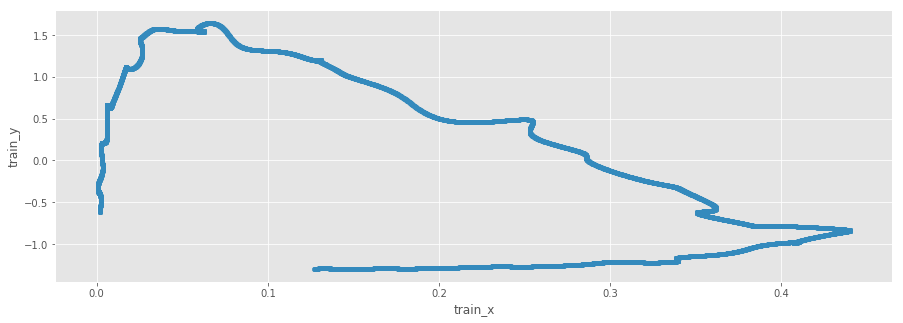

In [19]:
df.plot.scatter(x='train_x', y='train_y', figsize=(15,5))

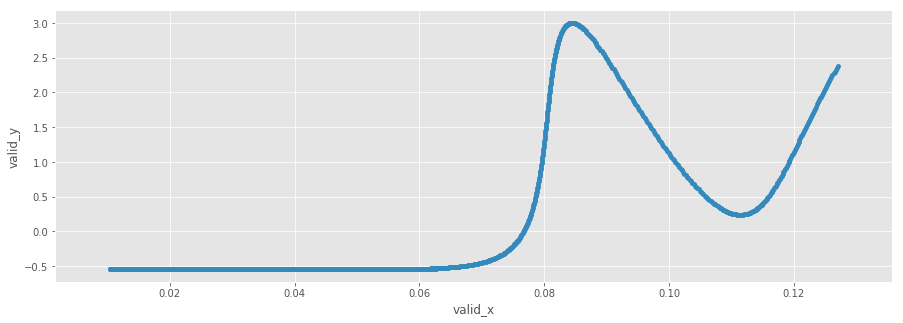

In [20]:
df_valid.plot.scatter(x='valid_x', y='valid_y', figsize=(15,5))

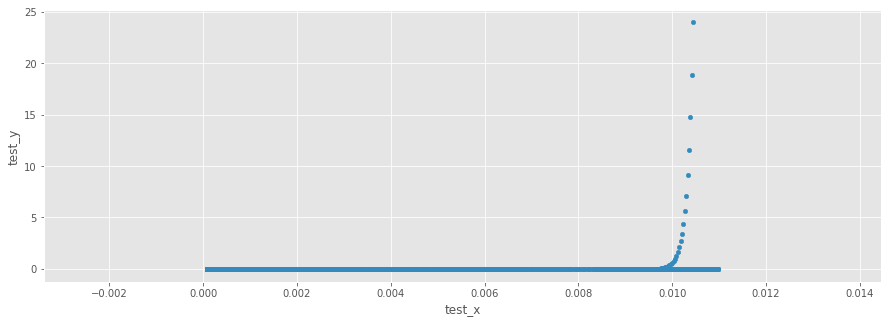

In [21]:
df_test.plot.scatter(x='test_x', y='test_y', figsize=(15,5))

In [22]:
def add_layer(inputs, in_size, out_size, activation_function=None):
    # tf.random_normal([what is the size of your batches, size of output layer])
    Weights = tf.Variable(tf.truncated_normal([in_size, out_size], mean=0.1, stddev=0.1))
    # tf.random_normal([size of output layer])
    biases = tf.Variable(tf.truncated_normal([out_size], mean=0.1, stddev=0.1))
    # shape of pred = [size of your batches, size of output layer]
    pred = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = pred
    else:
        outputs = activation_function(pred)
    return outputs

In [23]:
# larger batch sizes help you get to the local minimum faster at a cost of more cpu power
# The strategy is to use batch_size when you cannot fit the entire dataset into memory
# In practice, small to moderate mini-batches (10-500) are generally used
batch_size = 100

In [24]:
# you can adjust the number of neurons in the hidden layers here
hidden_size = 10
# placeholders
# shape=[how many samples do you have, how many input neurons]
x = tf.placeholder(tf.float32, shape=[None, 1], name="01_x")
y = tf.placeholder(tf.float32, shape=[None, 1], name="01_y")
print("shape of x and y:")
print(x.get_shape(),y.get_shape())

shape of x and y:
(?, 1) (?, 1)


In [25]:
# drop out
keep_prob = tf.placeholder(tf.float32)

In [26]:
# create your hidden layers!
h1 = add_layer(x, 1, hidden_size, tf.nn.relu)

# here is where we shoot down some of the neurons
h1_drop = tf.nn.dropout(h1, keep_prob)

# add a second layer
h2 = add_layer(h1_drop, hidden_size, hidden_size, tf.nn.relu)
h2_drop = tf.nn.dropout(h2, keep_prob)

# add a third layer
h3 = add_layer(h2_drop, hidden_size, hidden_size, tf.nn.relu)
h3_drop = tf.nn.dropout(h3, keep_prob)

# add a fourth layer
h4 = add_layer(h3_drop, hidden_size, hidden_size, tf.nn.relu)
h4_drop = tf.nn.dropout(h4, keep_prob)

print("shape of hidden layers:")
print(h1_drop.get_shape(), h2_drop.get_shape(), h3_drop.get_shape(), h4_drop.get_shape())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
shape of hidden layers:
(?, 10) (?, 10) (?, 10) (?, 10)


In [27]:
# Output Layers
pred = add_layer(h4_drop, hidden_size, 1)

print("shape of output layer:")
print(pred.get_shape())

shape of output layer:
(?, 1)


In [28]:
# minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(pred - y))
# pick optimizer
optimizer = tf.train.GradientDescentOptimizer(0.001)
train = optimizer.minimize(loss)

In [35]:
# Create variable to save and restore all of your variables
saver = tf.train.Saver()
# path
save_path = "E:/Model/model_" + datetime.datetime.now().strftime('%Y-%m-%d')

In [36]:
# check accuracy of model
correct_prediction = tf.equal(tf.round(pred), tf.round(y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [31]:
# Best validation accuracy seen so far.
best_valid_acc = 0.0
# Iteration-number for last improvement to validation accuracy.
last_improvement = 0
# Stop optimization if no improvement found in this many iterations.
require_improvement = 15000

In [37]:
# initialize the variables
init = tf.global_variables_initializer()
# hold step and error values
t = []
# Run your graph
with tf.Session() as sess:
    
    # restore model (no need to initialize variables if restorint model)
#     saver.restore(sess, save_path=save_path)
    
    # initialize variables
    sess.run(init)

    # Fit the function.
    for step in range(60000):
        # pull batches at random
        i = np.random.permutation(train_x.shape[0])[:batch_size]
        # get your data
        train_data = {x:train_x[i,:], y:train_y[i,:], keep_prob: 0.98}
        valid_data = {x:valid_x, y:valid_y, keep_prob: 1.0}
        test_data = {x:test_x, y:test_y, keep_prob: 1.0}
        
        # training in progress...
        train_loss, train_pred = sess.run([loss, train], feed_dict=train_data)        
        
        # print every n iterations
        if step%1000==0:
           
            # capture the step and error for analysis
            valid_loss = sess.run(loss, feed_dict=valid_data) 
            t.append((step, train_loss, valid_loss))    
            
            # get snapshot of current training and validation accuracy       
            train_acc = accuracy.eval(train_data)
            valid_acc = accuracy.eval(valid_data)           

            # If validation accuracy is an improvement over best-known.
            if valid_acc > best_valid_acc:
                # Update the best-known validation accuracy.
                best_valid_acc = valid_acc
                
                # Set the iteration for the last improvement to current.
                last_improvement = step
                
                # Save model to disk
#                 saver.save(sess, save_path=save_path)    
                # Flag when ever an improvement is found
                improved_str = '*'
            else:
                # An empty string to be printed below.
                # Shows that no improvement was found.
                improved_str = ''   
                
            print("Training loss at step %d: %f %s" % (step, train_loss, improved_str))        
            print("Validation %f" % (valid_loss))            
                
            # If no improvement found in the required number of iterations.
            if step - last_improvement > require_improvement:
                print("No improvement found in a while, stopping optimization.")
                # Break out from the for-loop.
                break 
            
    # here is where you see how good of a Data Scientist you are        
    print("Accuracy on the Training Set:", accuracy.eval(train_data) )
    print("Accuracy on the Validation Set:", accuracy.eval(valid_data) ) 
    print("Accuracy on the Test Set:", accuracy.eval(test_data) )
    
    # capture predictions on test data 
    test_results = sess.run(pred, feed_dict={x:test_x, keep_prob: 1.0})  
    df_final = pd.DataFrame({'test_x':test_x[:,0], 'pred':test_results[:,0]})
    
    # capture training and validation loss
    df_loss = pd.DataFrame(t, columns=['step', 'train_loss', 'valid_loss'])

Training loss at step 0: 1.534492 *
Validation 1.296623
Training loss at step 1000: 1.011137 *
Validation 0.997573
Training loss at step 2000: 1.083055 
Validation 0.998416
Training loss at step 3000: 1.018697 
Validation 0.998629
Training loss at step 4000: 0.943685 
Validation 0.999178
Training loss at step 5000: 1.010220 
Validation 0.999560
Training loss at step 6000: 1.051914 
Validation 0.999486
Training loss at step 7000: 1.125096 
Validation 0.999623
Training loss at step 8000: 1.096882 
Validation 0.999767
Training loss at step 9000: 1.028139 
Validation 0.999902
Training loss at step 10000: 0.862063 
Validation 1.000029
Training loss at step 11000: 1.074752 
Validation 1.000140
Training loss at step 12000: 0.970986 
Validation 1.000284
Training loss at step 13000: 1.017228 
Validation 1.000365
Training loss at step 14000: 1.052694 
Validation 1.000698
Training loss at step 15000: 1.051817 
Validation 1.000896
Training loss at step 16000: 1.003567 
Validation 1.000973
Training

In [38]:
# check accuracy of model
correct_prediction = tf.equal(tf.round(pred), tf.round(y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

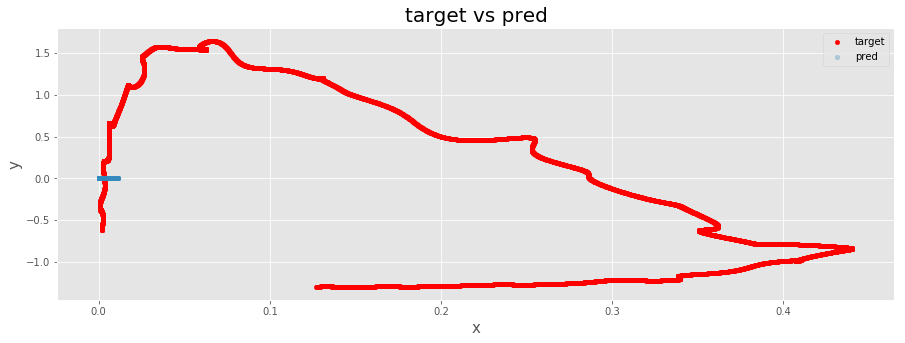

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# Chart 1 - Shows the line we are trying to model
df.plot.scatter(x='train_x', y='train_y', ax=axes, color='red')

# Chart 2 - Shows the line our trained model came up with
df_final.plot.scatter(x='test_x', y='pred', ax=axes, alpha=0.3)

# add a little sugar
axes.set_title('target vs pred', fontsize=20)
axes.set_ylabel('y', fontsize=15)
axes.set_xlabel('x', fontsize=15)
axes.legend(["target", "pred"], loc='best');

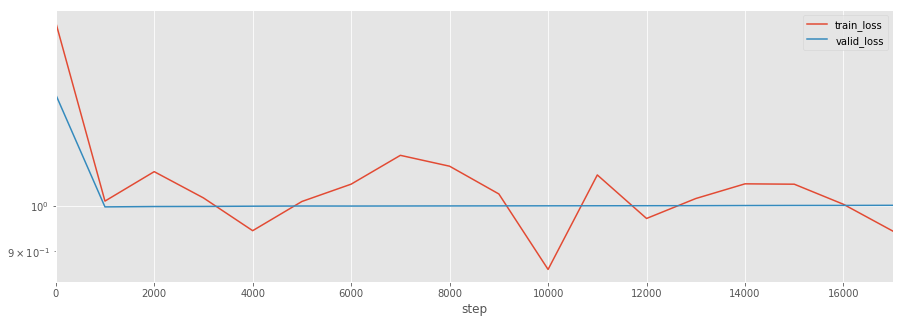

In [40]:
df_loss.set_index('step').plot(logy=True, figsize=(15,5))